In [1]:
import get_surya 
import get_funsd 
import get_azure

In [2]:
funsd = get_funsd.CustomFunsdDataset()
funsd.split_generators()

In [3]:
surya = get_surya.CustomSuryaDataset()
surya.split_generators()

In [4]:
azure = get_azure.CustomAzureDataset()
azure.split_generators()

In [5]:
azure['train'][0].keys()

dict_keys(['id', 'tokens', 'line_boxes', 'bboxes', 'handwritings', 'image', 'image_name'])

In [6]:
surya['train'][0].keys()

dict_keys(['id', 'tokens', 'line_boxes', 'image', 'image_name'])

In [141]:
funsd

CustomFunsdDataset:
DatasetDict({
    train: Dataset({features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 149}),
    test: Dataset({features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 50})
})

#### azure doesnt have non asci boxesss SOS

In [153]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)  # ASCII characters have ordinals less than 128

for i, img in enumerate(funsd['train']):
    tokens = funsd['train'][i]['tokens']
    boxes = funsd['train'][i]['ner_boxes']
     
    for j,token in enumerate(tokens):
        if not is_ascii(token):  # Check if token contains non-ASCII characters
            
            same_entity = [funsd['train'][i]['tokens'][k]
                           for k in range(len(funsd['train'][i]['ner_boxes'])) 
                     if funsd['train'][i]['ner_boxes'][k] == list(boxes[j])] 
                    

            if len(same_entity)  == 1 :
                print(token)
                print(funsd['train'][i]['linkings'][j])
                print(img['image_name'], i)


☑
[7]
0001485288.json 15
☑
[10]
00040534.json 16
☑
[57]
00040534.json 16
☑
[2]
0060036622.json 44
☑
[58]
0060077689.json 46
Tοpic
[79]
0060262650.json 56
☑
[15]
00836244.json 63
☑
[1]
00851772_1780.json 67
☑
[7]
00851879.json 68
☑
None
00860012_00860014.json 69
☑
[57]
00866042.json 71
☑
[54]
00866042.json 71
☑
[8]
01073843.json 75
☑
[15]
12825369.json 85
☑
[1]
13149651.json 86
☑
[49]
13149651.json 86
☑
[11]
13149651.json 86
☐
[52]
13149651.json 86
☐
[52]
13149651.json 86
☑
[16]
13149651.json 86
☑
[17]
13149651.json 86
Bogotá:
[43, 42]
71563825.json 94
☑
[8]
716552.json 96
☑
[6]
716552.json 96
☐
None
716552.json 96
☑
[12]
716552.json 96
☑
[2]
80310840a.json 97
☑
[34]
81619511_9513.json 105
☑
[12]
87672097.json 109
☑
[14]
87672097.json 109
☑
[10]
89817999_8002.json 115
☑
[18]
91856041_6049.json 127
☑
[20]
91856041_6049.json 127
198–
None
91903177.json 128
☑
[22]
92586242.json 141
☑
[20]
92586242.json 141


#### F1 ( without any post proccesing of ocr output)

In [104]:
tp_list = []
fp_list = []
fn_list = []
precision_list = []
recall_list = []
f1score_list = []

for i,img in enumerate(funsd['train']):    
    tp = len(set(azure['train'][i]['tokens']) & set(funsd['train'][i]['tokens']))
    tp_list.append(tp)
    
    fp = len(set(azure['train'][i]['tokens'])) - tp
    fp_list.append(fp)
    
    fn = len(set(funsd['train'][i]['tokens'])) - tp
    fn_list.append(fn)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    
    # appending precision, recall, and F1 score to the list
    precision_list.append(precision)
    recall_list.append(recall)
    f1score_list.append(f1)



import numpy as np

mean_f1 = np.mean(f1score_list)
std_f1 = np.std(f1score_list)
mean_precision = np.mean(precision_list)
std_precision = np.std(precision_list)
mean_recall = np.mean(recall_list)
std_recall = np.std(recall_list)



# Calculate overall true positives, false positives, and false negatives
tp_sum = sum(tp_list)
fp_sum = sum(fp_list)
fn_sum = sum(fn_list)

# Calculate overall F1 score, precision, and recall
overall_f1 = 2 * tp_sum  / (2 * tp_sum  + fp_sum + fn_sum)
overall_precision = tp_sum  / (tp_sum  + fp_sum)
overall_recall = tp_sum  / (tp_sum  + fn_sum)

print(f"Overall F1 score: {overall_f1:.3f}")
print(f"Overall_precision: {overall_precision:.3f}")
print(f"Overall_recall: {overall_recall:.3f}")

Overall F1 score: 0.816
Overall_precision: 0.819
Overall_recall: 0.813


In [7]:
def iou(gt_box, ocr_line_box):
    x1, y1, x2, y2 = gt_box
    x1_p, y1_p, x2_p, y2_p = ocr_line_box

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    gt_box_area = (x2 - x1) * (y2 - y1)
    ocr_line_box_area = (x2_p - x1_p) * (y2_p - y1_p)
    
    union_area = gt_box_area + ocr_line_box_area - inter_area
    return inter_area / union_area if union_area else 0
  

In [8]:
def is_box_inside(inner_box, outer_box, tolerance=0):
    """
    Check if inner_box is inside outer_box with a given tolerance for error.
    
    Args:
    - inner_box: [x_min, y_min, x_max, y_max] for the inner box.
    - outer_box: [x_min, y_min, x_max, y_max] for the outer box.
    - tolerance: Allowed deviation (error) for the box positions and dimensions.
    
    Returns:
    - True if inner_box is inside outer_box within the given tolerance, else False.
    """
    # Check if inner_box is inside outer_box with the given tolerance
    return (
        inner_box[0] >= outer_box[0] - tolerance and  # inner x_min >= outer x_min - tolerance
        inner_box[1] >= outer_box[1] - tolerance and  # inner y_min >= outer y_min - tolerance
        inner_box[2] <= outer_box[2] + tolerance and  # inner x_max <= outer x_max + tolerance
        inner_box[3] <= outer_box[3] + tolerance      # inner y_max <= outer y_max + tolerance
    )


In [164]:
def map_gt_tokens(image_index, ocr, check_function, *args, **kwargs):

         
    found_gt_tokens = {str(funsd['train'][image_index]['tokens'][i])+'_'+
                       str(funsd['train'][image_index]['bboxes'][i]):[]
                    for i in range(len(funsd['train'][image_index]['tokens']))}

    funsd_bboxes = funsd['train'][image_index]['bboxes']

    # get unique ocr line boxes
    if check_function.__name__ == 'is_box_inside':
        ocr_line_boxes = ocr['train'][image_index]['line_boxes']
        ocr_unique_boxes = list(dict.fromkeys(tuple(box) for box in ocr_line_boxes))
        
        print(check_function.__name__)
        c = 0
        for i, ocr_box in enumerate(ocr_unique_boxes):
            for j, box in enumerate(funsd_bboxes):
                
                if is_box_inside(box, ocr_box,*args, **kwargs):
                    # print(iou_score)
                    # for bi, b in enumerate(ocr_line_boxes):
                    #     if b == list(ocr_line_box):
                    #         print(ocr['train'][image_index]['tokens'][bi],end=' ')
                    # print('')
                    # print(box, ocr_line_box)
                    # print(funsd['train'][image_index]['tokens'][j])
                    # print('_______________'*4)
                    
                    all_line_tokens = [ocr['train'][image_index]['tokens'][k]
                     for k in range(len(ocr['train'][image_index]['line_boxes'])) 
                     if ocr['train'][image_index]['line_boxes'][k] == list(ocr_box)]   
                    
                    found_gt_tokens[str(funsd['train'][image_index]['tokens'][j])+'_'+
                                    str(funsd['train'][image_index]['bboxes'][j])].append(
                                        all_line_tokens
                                    )
                    c+=1        

        return found_gt_tokens 
    
    elif check_function.__name__ == 'iou':
        ocr_unique_boxes = ocr['train'][image_index]['bboxes']
        print(check_function.__name__)
        c = 0
        for i, ocr_box in enumerate(ocr_unique_boxes):
            for j, box in enumerate(funsd_bboxes):
                
                if iou(box, ocr_box)>0.5:
                    found_gt_tokens[str(funsd['train'][image_index]['tokens'][j])+'_'+
                                    str(funsd['train'][image_index]['bboxes'][j])].extend(
                                        ocr['train'][image_index]['tokens'][i]
                                    )
                    c+=1
        

        return found_gt_tokens 
        
    else:
        print('Wrong check function')
        return None
    

In [175]:
def get_gt_tokens_not_found(image_index, ocr, check_function, *args, **kwargs):
    
    found_gt_tokens = map_gt_tokens(image_index, ocr, check_function, *args, **kwargs)
    gt_tokens_not_found = [key for key, value in found_gt_tokens.items() if len(value) == 0]
    
    return gt_tokens_not_found

In [166]:
box = get_gt_tokens_not_found(113,azure, is_box_inside, tolerance=10)
iouu = get_gt_tokens_not_found(113,azure, iou)

is_box_inside
iou


In [205]:
c= 0
for i in range(len(azure['train'])):
    for  k,v  in map_gt_tokens(i
                ,azure, is_box_inside, tolerance=10).items():
        if k.split('_')[0] in ['☑' , '☐']:  
            c+=1
            print(k, v, i)


is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
☐_[304, 644, 324, 664] [] 5
☐_[362, 644, 380, 664] [] 5
☐_[409, 642, 430, 663] [] 5
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
☑_[108, 409, 150, 434] [] 12
is_box_inside
is_box_inside
is_box_inside
☑_[482, 102, 497, 115] [['SPECIAL', 'SAMPLE', 'MANUFACTURE', '[x]']] 15
☐_[482, 123, 499, 137] [] 15
☐_[482, 142, 496, 157] [] 15
☐_[482, 165, 497, 179] [] 15
is_box_inside
☑_[288, 360, 302, 373] [['CXP.O.']] 16
☑_[201, 388, 218, 406] [['>', '.5', '%', 'METHYL', 'CELLULOSE']] 16
☐_[362, 362, 372, 373] [] 16
☐_[429, 362, 440, 373] [] 16
☐_[499, 365, 510, 375] [['O', 'INHALATION']] 16
☐_[369, 390, 383, 403] [['D', 'CORN', 'OIL']] 16
☐_[466, 390, 479, 401] [['SALINE']] 16
☐_[550, 391, 563, 404] [['OTHER']] 16
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_inside
is_box_insi

In [202]:
c

123

In [206]:
more_than1 = get_gt_tokens_not_found(141,azure, is_box_inside, tolerance=10)
more_than1

is_box_inside


[]

In [212]:
len1tokens = {}
for i,img in enumerate(funsd['train']):
    # boxes = img['ner_boxes']
    # same_entity = [funsd['train'][i]['tokens'][k]
    #                        for k in range(len(funsd['train'][i]['ner_boxes'])) 
    #                  if funsd['train'][i]['ner_boxes'][k] == box] 
    tokens = img['tokens']
    for token in tokens:
        if len(token) == 1:
            if token not in len1tokens:
                len1tokens[token] = 1
            else :
                len1tokens[token] += 1

In [235]:
len1tokens = {}
for i,img in enumerate(funsd['train']):
    boxes = img['ner_boxes']
    for box in boxes:
        same_entity = [funsd['train'][i]['tokens'][k]
                           for k in range(len(funsd['train'][i]['ner_boxes'])) 
                     if funsd['train'][i]['ner_boxes'][k] == box] 
    # tokens = img['tokens'
        if len(same_entity) > 150:
            print(tokens,end=' ')
            print('')

In [220]:
sorted(len1tokens.items(), key=lambda x: x[1], reverse=True)

[('-', 201),
 (':', 108),
 ('&', 79),
 ('.', 68),
 ('a', 64),
 ('#', 61),
 ('x', 54),
 ('X', 53),
 ('1', 49),
 ('$', 34),
 ('%', 33),
 ('2', 30),
 ('3', 29),
 ('O', 29),
 (')', 26),
 ('(', 25),
 ('0', 24),
 ('A', 22),
 ('/', 21),
 ('I', 20),
 ('4', 19),
 ('5', 19),
 ('D', 18),
 ('7', 15),
 ('*', 15),
 ('8', 14),
 ('6', 14),
 ('9', 12),
 ('=', 12),
 (',', 10),
 ('+', 9),
 ('@', 9),
 ('C', 7),
 ('"', 6),
 ('>', 6),
 ('_', 6),
 ('B', 5),
 ('~', 5),
 ('L', 4),
 ('T', 4),
 ('W', 3),
 ('N', 3),
 ('{', 2),
 ('M', 2),
 ('P', 2),
 ('g', 2),
 ('V', 2),
 ('S', 2),
 (']', 2),
 ('E', 2),
 ('!', 2),
 ('m', 1),
 ('×', 1),
 ('F', 1),
 (';', 1),
 ('≤', 1),
 ('K', 1),
 ('·', 1),
 ('Q', 1),
 ('Z', 1),
 ('R', 1),
 ('H', 1),
 ('Y', 1),
 ('℃', 1),
 ('[', 1),
 ('|', 1),
 ('i', 1)]

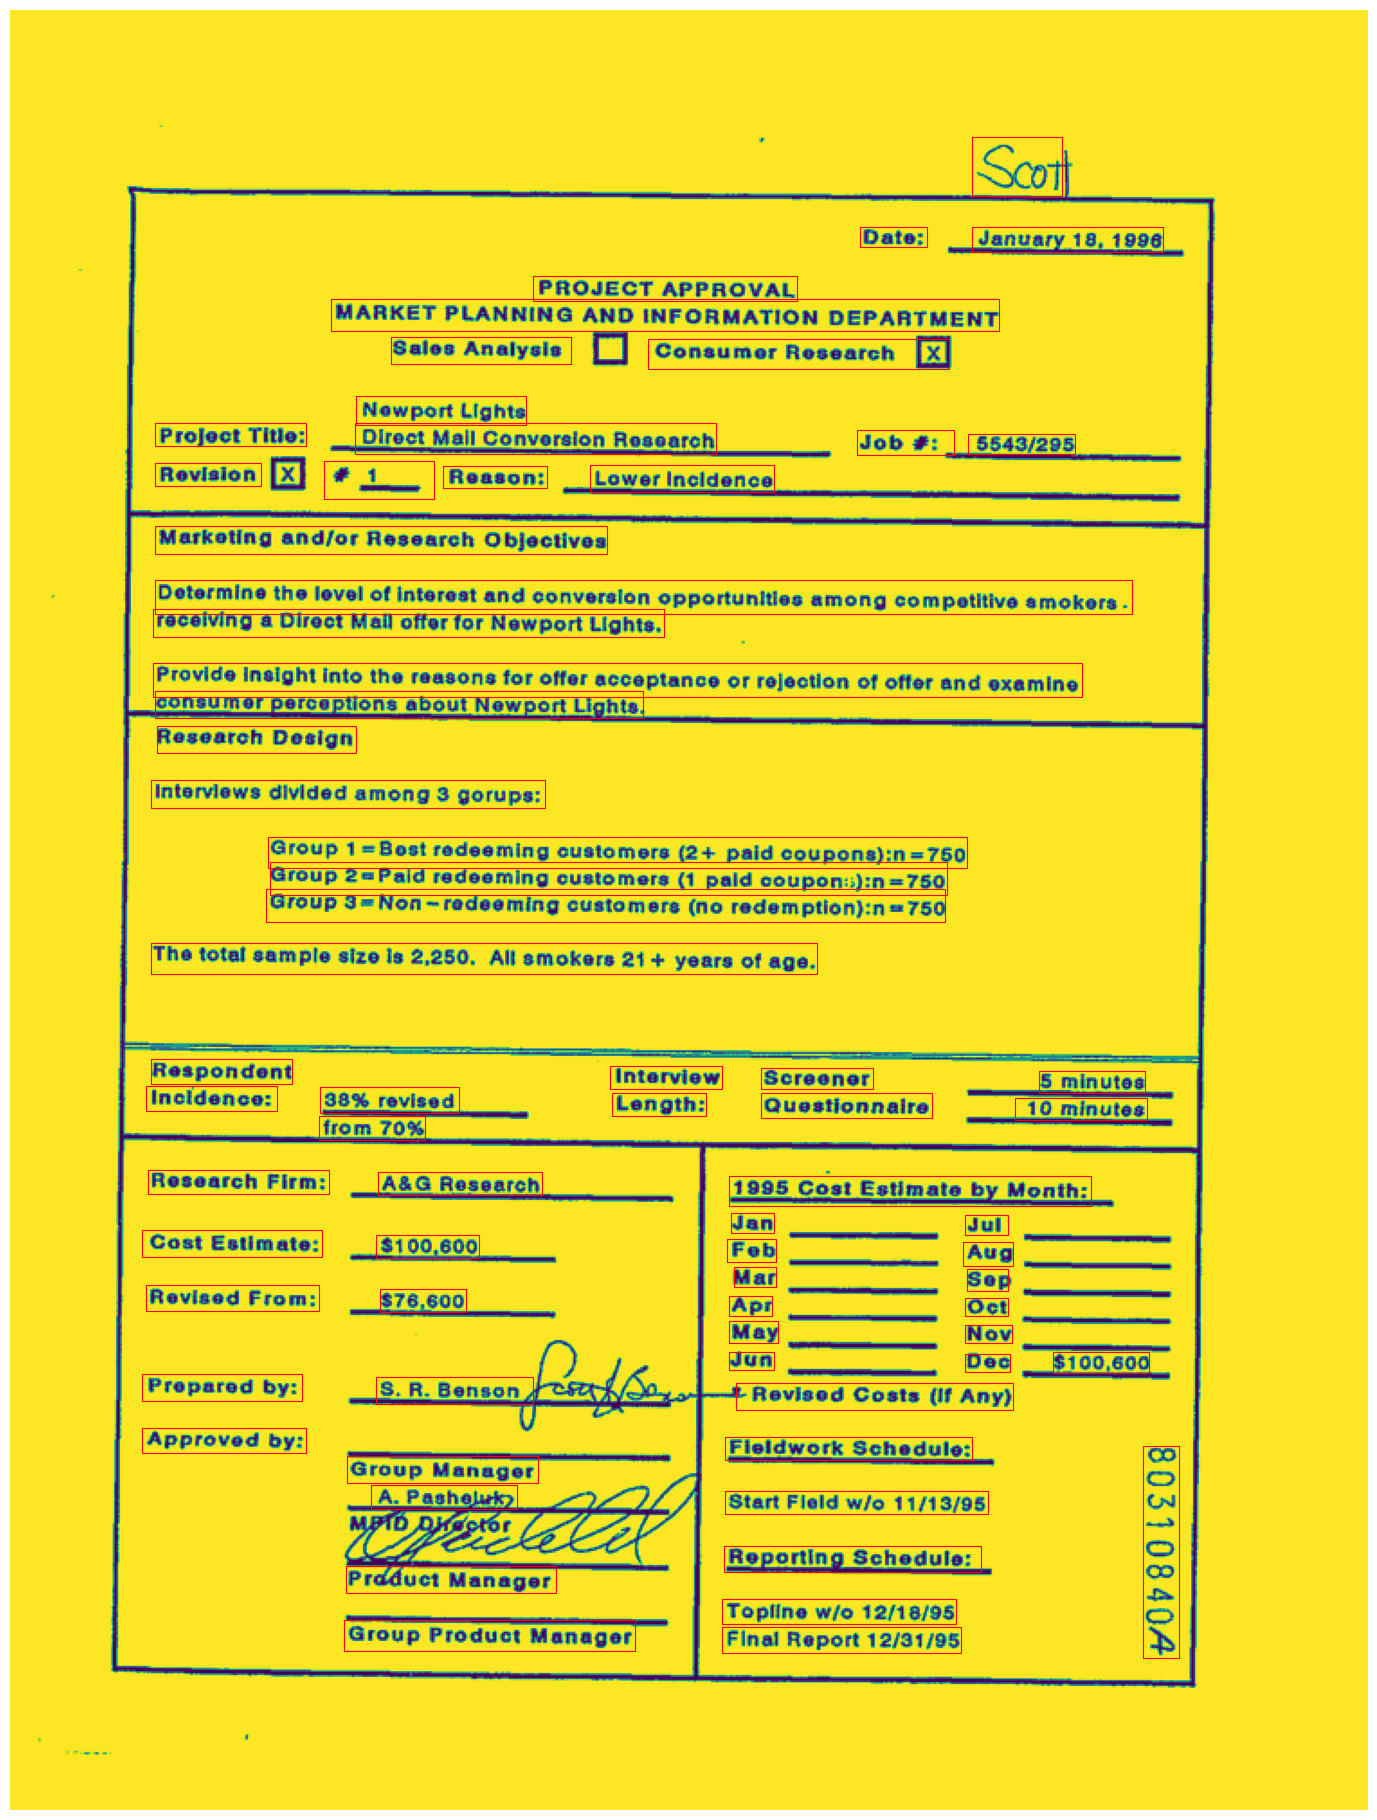

In [154]:
from PIL import Image
import matplotlib.pyplot as plt
import io 

i=97
image = azure['train'][i]['image']
fig, ax = plt.subplots(1, figsize=(20, 18))
ax.imshow(image)
azure_unique_line_boxes = list(dict.fromkeys(tuple(box) for box in azure['train'][i]['line_boxes']))
for pred in azure_unique_line_boxes:

    x0, y0, x1, y1 = pred
    width = x1 - x0
    height = y1 - y0
    rect = plt.Rectangle((x0, y0), width, height, fill=False, color='r', linewidth=0.8)
    ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout(pad=0)

    

is_box_inside


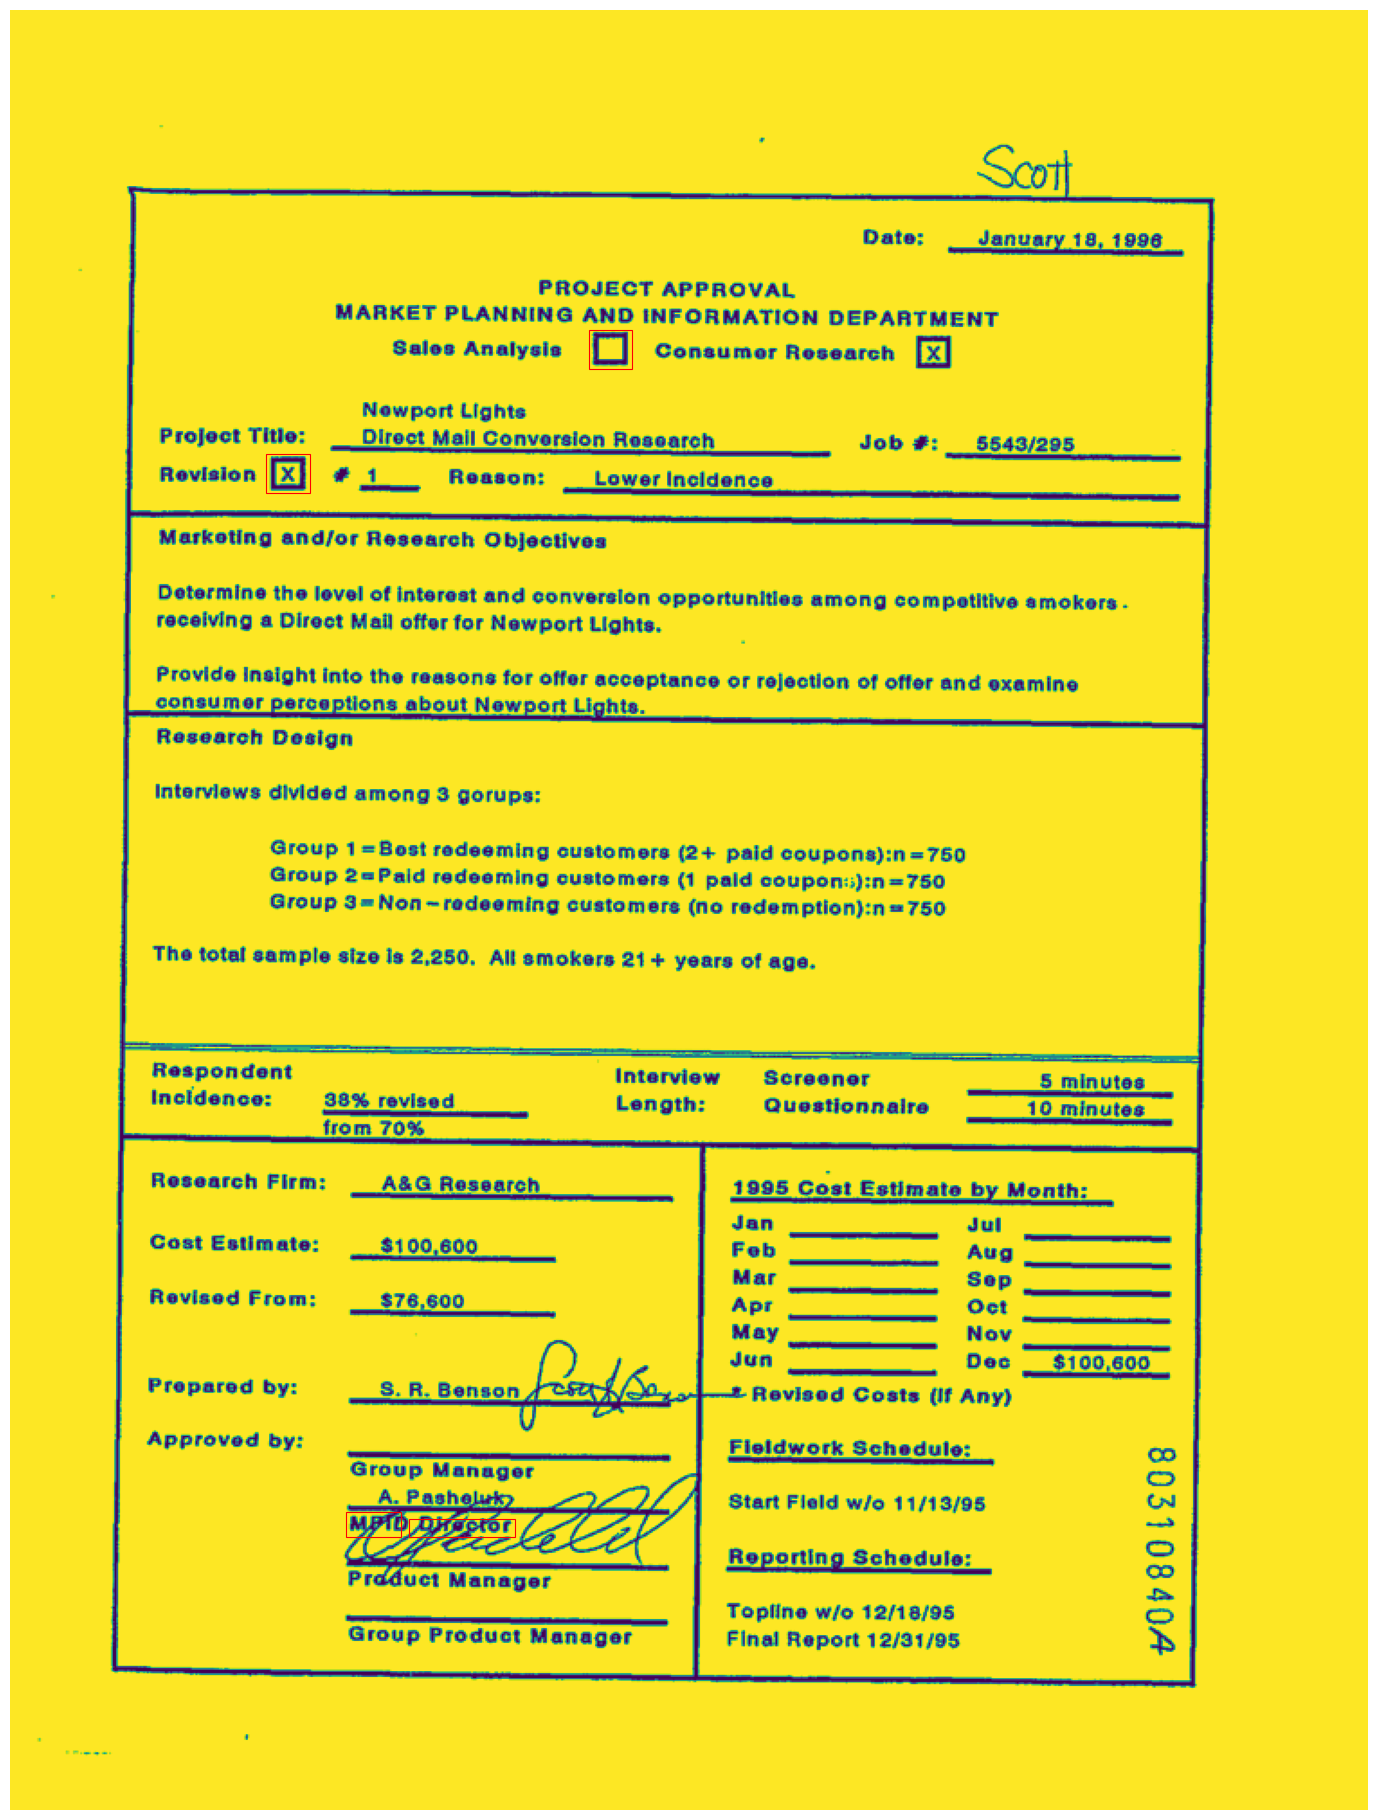

In [198]:
from PIL import Image
import matplotlib.pyplot as plt
import io 
import ast

i=97
image = azure['train'][i]['image']
fig, ax = plt.subplots(1, figsize=(20, 18))
ax.imshow(image)
azure_unique_line_boxes = get_gt_tokens_not_found(i, azure, is_box_inside, tolerance=10)
for pred in azure_unique_line_boxes:
    pred = pred.split('_')[1]
    pred = ast.literal_eval(pred)
    x0, y0, x1, y1 = pred
    width = x1 - x0
    height = y1 - y0
    rect = plt.Rectangle((x0, y0), width, height, fill=False, color='r', linewidth=0.8)
    ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout(pad=0)

    

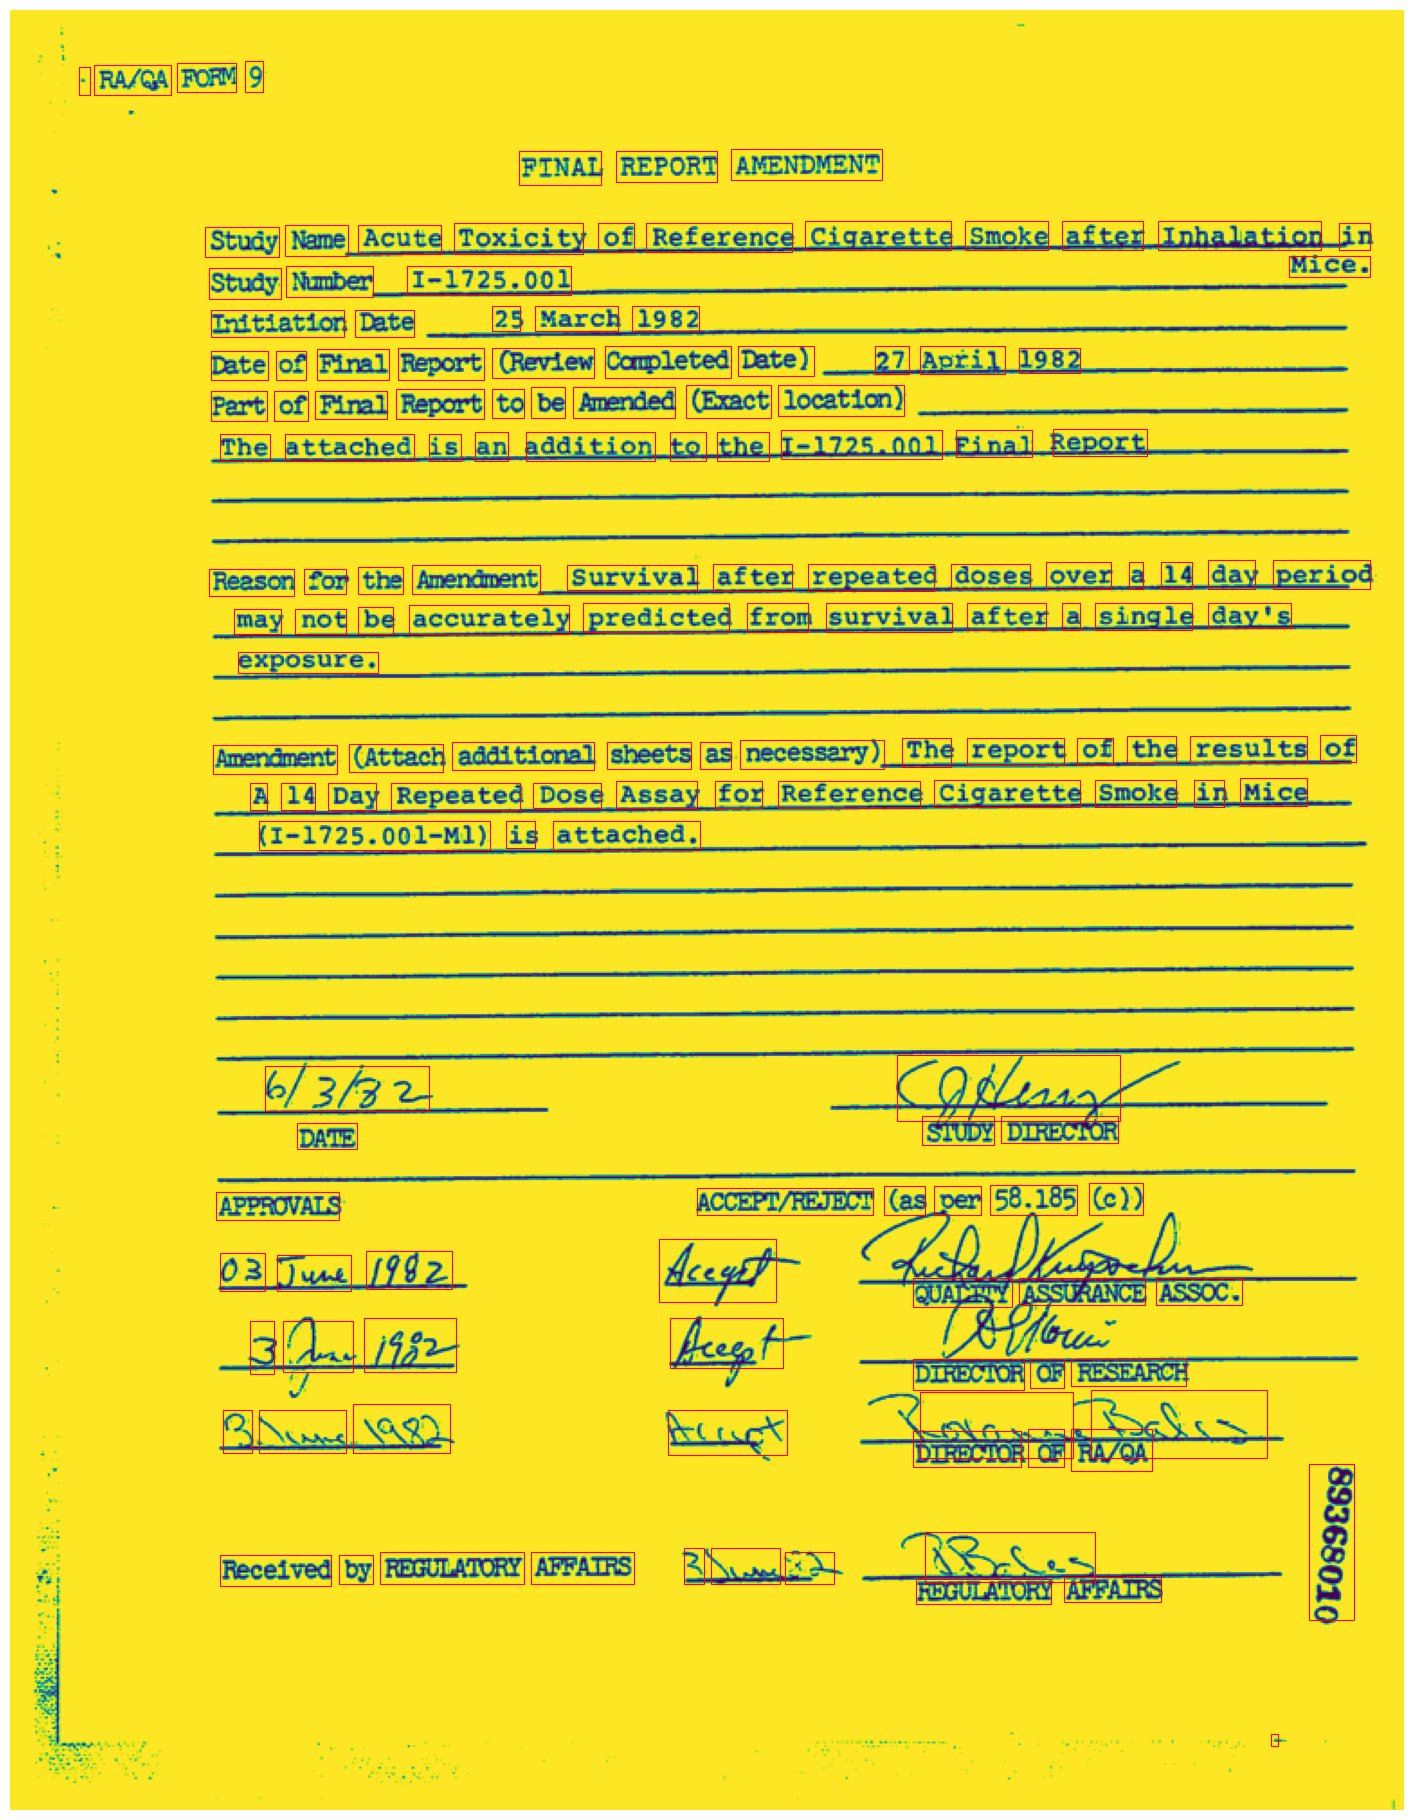

In [113]:
from PIL import Image
import matplotlib.pyplot as plt
import io 

i=113
image = azure['train'][i]['image']
fig, ax = plt.subplots(1, figsize=(20, 18))
ax.imshow(image)
azure_unique_boxes = azure['train'][i]['bboxes'] 
for pred in azure_unique_boxes:
    x0, y0, x1, y1 = pred
    width = x1 - x0
    height = y1 - y0
    rect = plt.Rectangle((x0, y0), width, height, fill=False, color='r', linewidth=0.8)
    ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout(pad=0)

    